In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
from functools import partial
sys.path.append('../../')

import jax
import jax.numpy as jnp
from ml_collections import ConfigDict
import matplotlib.pyplot as plt
from matplotlib import colormaps
import orbax.checkpoint
from flax.training import orbax_utils


from sdebridge.sde import FourierGaussianKernelSDE
from sdebridge.diffusion_bridge import DiffusionBridge
from sdebridge.utils import create_train_state
from sdebridge.networks import ScoreUNet

2024-01-31 19:41:36.422569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 19:41:36.422606: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 19:41:36.423633: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 19:41:37.824927: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/gefan/miniconda3/envs/sdebridge/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonoteboo

### Read pre-processed butterfly data

In [3]:
def plot_butterfly_pts(pts, ax, color='r', label=None):
    ax.scatter(pts[:, 0], pts[:, 1], color=color, label=label, s=10)
    ax.plot(pts[:, 0], pts[:, 1], color=color, alpha=0.5, linestyle='--')
    return ax

initial_butterfly.shape (120, 2)
target_butterfly.shape (120, 2)


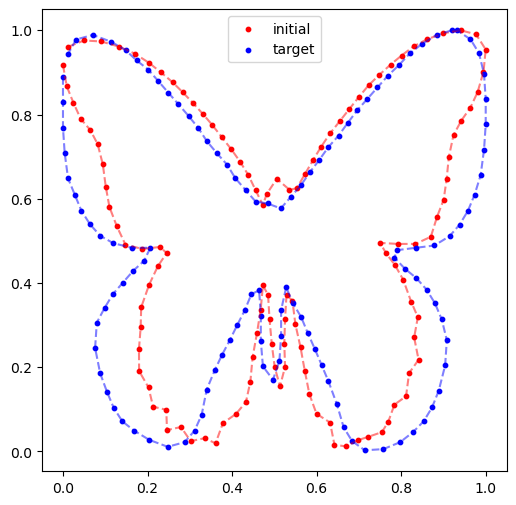

In [4]:
initial_butterfly = jnp.load('../data/tom_pts.npy')
target_butterfly = jnp.load('../data/honrathi_pts.npy')
print("initial_butterfly.shape", initial_butterfly.shape)
print("target_butterfly.shape", target_butterfly.shape)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_butterfly_pts(initial_butterfly, ax, color='r', label='initial')
ax = plot_butterfly_pts(target_butterfly, ax, color='b', label='target')
ax.legend()
plt.show()

### Set up SDE

In [17]:
n_bases = 8
n_pts = initial_butterfly.shape[0]

sde_config = ConfigDict(
    {
        'init_S': initial_butterfly,
        'n_bases': n_bases,
        'n_grid': 64,
        'grid_range': [-1.5, 1.5],
        'alpha': 1.0,
        'sigma': 0.1,
        'T': 1.0,
        'N': 50,
        'dim': 2
    }
)

sde = FourierGaussianKernelSDE(sde_config)
bridge = DiffusionBridge(sde)

### Set the initial and target deformation

untruncated target_diff_coeffs.shape (120, 2)
initial_diff_coeffs.shape (8, 2)
target_diff_coeffs.shape (8, 2)


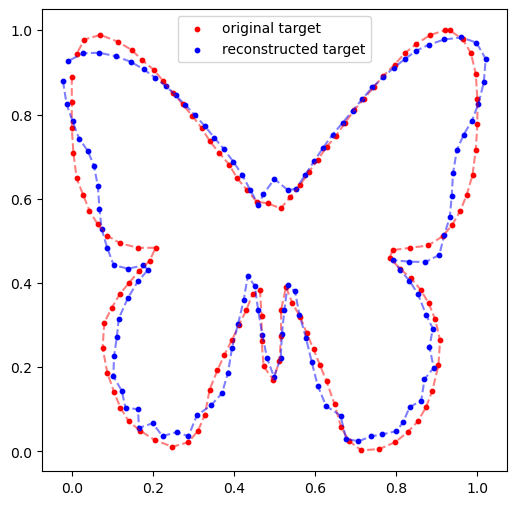

initial_diff_flatten.shape (16,)
target_diff_flatten.shape (16,)


In [18]:
initial_diff_coeffs = jnp.zeros((n_bases, 2), dtype=jnp.complex64)

target_diff = target_butterfly - initial_butterfly
target_diff_coeffs = jnp.fft.fft(target_diff, n=n_pts, axis=0, norm='backward')
target_diff_coeffs = jnp.fft.fftshift(target_diff_coeffs, axes=0)   # shift zero freqency to center for truncation
print("untruncated target_diff_coeffs.shape", target_diff_coeffs.shape)
target_diff_coeffs = target_diff_coeffs[
    (n_pts - n_bases) // 2: (n_pts + n_bases) // 2, :
]   # truncate low frequencies
print("initial_diff_coeffs.shape", initial_diff_coeffs.shape)
print("target_diff_coeffs.shape", target_diff_coeffs.shape)

# Using truncated target_diff_coeffs to reconstruct target_diff
target_diff_coeffs_padded = jnp.pad(
    target_diff_coeffs, 
    ((sde.n_padding, sde.n_padding), (0, 0)),
    mode='constant',
    constant_values=0
)
target_diff_coeffs_padded = jnp.fft.ifftshift(target_diff_coeffs_padded, axes=0)
target_diff_recon = jnp.fft.ifft(target_diff_coeffs_padded, n=n_pts, axis=0, norm='backward').real
target_butterfly_recon = target_diff_recon + initial_butterfly

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_butterfly_pts(target_butterfly, ax, color='r', label='original target')
ax = plot_butterfly_pts(target_butterfly_recon, ax, color='b', label='reconstructed target')
ax.legend()
plt.show()

initial_diff_flatten = jnp.concatenate(
    [initial_diff_coeffs[:, 0], initial_diff_coeffs[:, 1]],
    axis=0
)
target_diff_flatten = jnp.concatenate(
    [target_diff_coeffs[:, 0], target_diff_coeffs[:, 1]],
    axis=0
)
print("initial_diff_flatten.shape", initial_diff_flatten.shape)
print("target_diff_flatten.shape", target_diff_flatten.shape)

In [19]:
def reconstruct_trajectories(diff_coeffs_flatten_traj, initial_butterfly):
    diff_coeffs_traj = jnp.stack(
        jnp.split(diff_coeffs_flatten_traj, 2, axis=-1),
        axis=-1
    )
    diff_coeffs_traj_padded = jnp.pad(
        diff_coeffs_traj,
        ((0, 0), (0, 0), (sde.n_padding, sde.n_padding), (0, 0)),
        mode='constant',
        constant_values=0
    )
    diff_coeffs_traj_padded = jnp.fft.ifftshift(diff_coeffs_traj_padded, axes=-2)
    diff_traj_recon = jnp.fft.ifft(diff_coeffs_traj_padded, n=n_pts, axis=-2, norm='backward').real
    traj = diff_traj_recon + initial_butterfly[None, None, :, :]
    return traj

def plot_trajectories(traj, sample_idx, ax, cmap_name='viridis'):
    cmap = colormaps.get_cmap(cmap_name)
    colors = cmap(jnp.linspace(0, 1, traj.shape[-2]))
    for i in range(traj.shape[-2]):
        ax.scatter(traj[sample_idx, 0, i, 0], traj[sample_idx, 0, i, 1], color=colors[i], s=20, marker='o')
        ax.scatter(traj[sample_idx, -1, i, 0], traj[sample_idx, -1, i, 1], color=colors[i], s=20, marker='x')
        ax.plot(traj[sample_idx, :, i, 0], traj[sample_idx, :, i, 1], color=colors[i], alpha=0.3)
    return ax

### Unconditional forward process

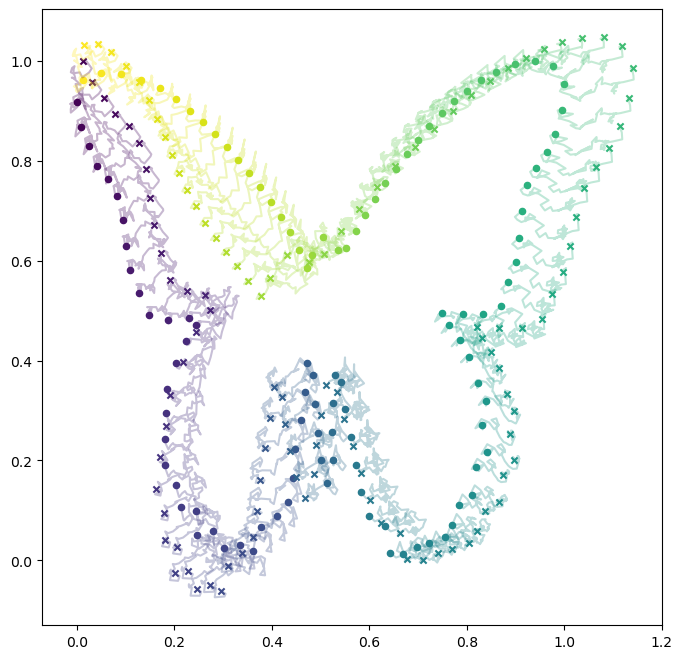

In [20]:
forward_unconditional = bridge.simulate_forward_process(
    initial_val = initial_diff_flatten,
    num_batches = 1
)

forward_unconditional_diff_coeffs = forward_unconditional["trajectories"]
forward_unconditional_traj = reconstruct_trajectories(
    forward_unconditional_diff_coeffs,
    initial_butterfly,
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plot_trajectories(forward_unconditional_traj, 0, ax)

### Learning backward score from unconditional forward process

In [21]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 64,
        "init_embedding_dim": 64,
        "act_fn": "silu",
        "encoder_layer_dims": [128, 64, 32, 16],
        "decoder_layer_dims": [16, 32, 64, 128],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 32,
        "num_epochs": 100,
        "num_batches_per_epoch": 300,
        "learning_rate": 1e-3,
        "warmup_steps": 2000,
    }
}

score_p_state = bridge.learn_p_score(
    initial_val=initial_diff_flatten,
    setup_params=setup_params,
)

Training: 100%|██████████| 100/100 [08:32<00:00,  5.12s/epoch, Epoch=100, loss=7.1591]


In [22]:
@partial(jax.jit, backend='gpu')
def score_p(val, time):
    score_output = score_p_state.apply_fn(
        {"params": score_p_state.params, "batch_stats": score_p_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

backward_bridge = bridge.simulate_backward_bridge(
    initial_val=initial_diff_flatten,
    terminal_val=target_diff_flatten,
    score_p=score_p,
    num_batches=8,
)

backward_bridge_diff_coeffs = backward_bridge["trajectories"]
backward_traj = reconstruct_trajectories(
    backward_bridge_diff_coeffs,
    initial_butterfly
)


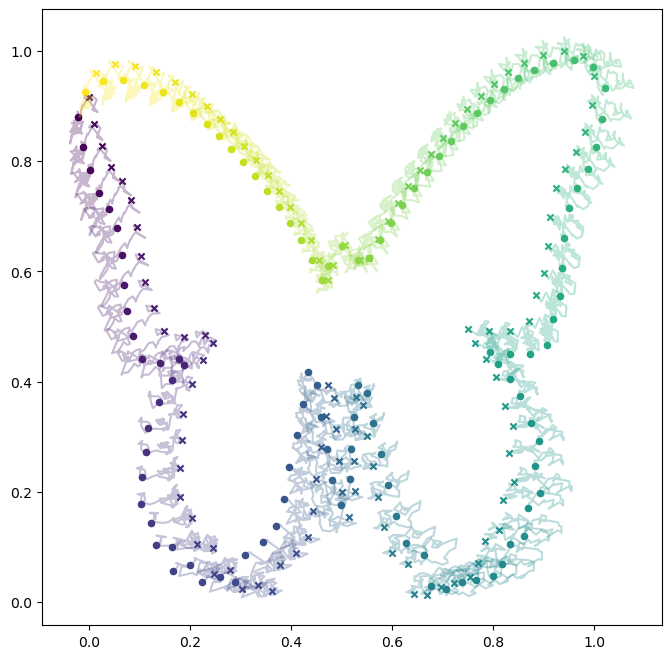

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plot_trajectories(backward_traj, 3, ax)

#### Save the model

In [25]:
score_p_ckpt = {
    "state": score_p_state,
    "training_config": setup_params,
}

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(score_p_ckpt)
orbax_checkpointer.save('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_8_bases', score_p_ckpt, save_args=save_args)

#### Reload the model

In [9]:
def load_ckpts(ckpt_path):
    orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
    ckpt_dict = orbax_checkpointer.restore(ckpt_path)
    network_config = ckpt_dict["training_config"]["network"]
    new_state = create_train_state(
        model=ScoreUNet(**network_config),
        rng_key=jax.random.PRNGKey(0),
        input_shapes=((1, 2*sde_config.dim*sde_config.n_bases), (1, 1)),
        learning_rate=0.01,
        warmup_steps=1,
        decay_steps=10
    )
    traget = {
        "state": new_state,
        "training_config": {},
    }
    ckpt = orbax_checkpointer.restore(ckpt_path, item=traget)
    return ckpt["state"]

In [10]:
new_state = load_ckpts('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_24_bases')

In [11]:
@partial(jax.jit, backend='gpu')
def score_p(val, time):
    score_output = new_state.apply_fn(
        {"params": new_state.params, "batch_stats": new_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

backward_bridge = bridge.simulate_backward_bridge(
    initial_val=initial_diff_flatten,
    terminal_val=target_diff_flatten,
    score_p=score_p,
    num_batches=8,
)

backward_bridge_diff_coeffs = backward_bridge["trajectories"]
backward_traj = reconstruct_trajectories(
    backward_bridge_diff_coeffs,
    initial_butterfly
)

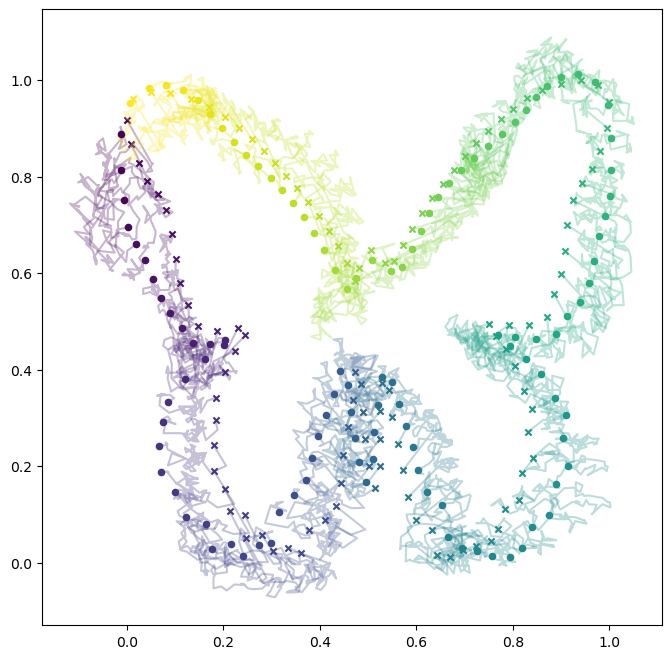

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plot_trajectories(backward_traj, 3, ax)

### Learning forward score from backward bridge process

In [51]:
setup_params = {
    "network": {
        "output_dim": 2*sde.dim*sde.n_bases,
        "time_embedding_dim": 32,
        "init_embedding_dim": 32,
        "act_fn": "silu",
        "encoder_layer_dims": [64, 32, 16, 8],
        "decoder_layer_dims": [8, 16, 32, 64],
        "batchnorm": True,
    },
    "training": {
        "batch_size": 64,
        "num_epochs": 100,
        "num_batches_per_epoch": 200,
        "learning_rate": 1e-3,
        "warmup_steps": 1000,
    }
}

score_p_star_state = bridge.learn_p_star_score(
    initial_val=initial_diff_flatten,
    terminal_val=target_diff_flatten,
    score_p=score_p,
    setup_params=setup_params,
)

Training: 100%|██████████| 100/100 [27:25<00:00, 16.46s/epoch, Epoch=100, loss=6.5715]


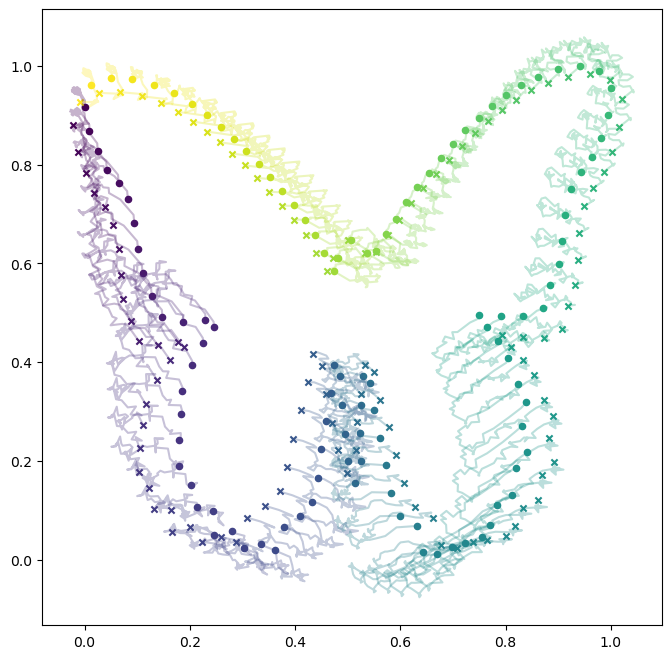

In [52]:
@partial(jax.jit, backend='gpu')
def score_p_star(val, time):
    score_output = score_p_star_state.apply_fn(
        {"params": score_p_star_state.params, "batch_stats": score_p_star_state.batch_stats},
        x_complex=val,
        t=time,
        train=False
    )
    score_real, score_imag = jnp.split(score_output, 2, axis=-1)
    score = score_real + 1j * score_imag
    return score

def score_h(val, time):
    return score_p_star(val, time) - score_p(val, time)

forward_bridge = bridge.simulate_forward_bridge(
    initial_val=initial_diff_flatten,
    terminal_val=target_diff_flatten,
    score_h=score_h,
    num_batches=8,
)

forward_bridge_diff_coeffs = forward_bridge["trajectories"]
forward_traj = reconstruct_trajectories(
    forward_bridge_diff_coeffs,
    initial_butterfly,
    'viridis'
)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax = plot_trajectories(forward_traj, 0, ax)

In [53]:
score_p_star_ckpt = {
    "model": score_p_star_state,
    "config": setup_params,
}

orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(score_p_star_ckpt)
orbax_checkpointer.save('/home/gefan/Projects/sdebridge/sdebridge/ckpts/score_p_star_8_bases', score_p_star_ckpt, save_args=save_args)